In [659]:
import numpy as np
import random
import math
from random import choice
import json
import time
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

In [660]:
with open("input-data.json", "r") as f:
    config_data = json.load(f)

In [661]:
class Patch:
    def __init__(self, index_array, climate_zone_array, soil_quality_array, config):
        self.index = index_array.astype(np.int32)
        self.climate_zone = climate_zone_array
        self.soil_quality = soil_quality_array
        self.soil_factor = np.vectorize(config["SOILS"].get)(soil_quality_array)
        self.grass = np.full_like(index_array, config.get("GRASS_START", 0), dtype=np.int32)
        self.max_grass = np.full_like(index_array, config.get("GRASS_MAX", 1), dtype=np.int32)
        self.temperature = np.zeros_like(index_array, dtype=np.int32)

    def grow_grass(self, grass_speed):
        delta = self.soil_factor * self.temperature * grass_speed
        self.grass = np.minimum(self.grass + delta, self.max_grass)

In [662]:
class World:
    def __init__(self, config_data):
        self.config_data = config_data
        self.length = config_data["LENGTH"]
        self.grow_speed = config_data["GROW_SPEED"]

        self.patches = None
        self.temperature_patterns = config_data["CLIMATES"]
        self.current_tick = 0

        self.init_patches()

    def init_patches(self):
        idx = np.arange(self.length, dtype=np.int32)

        climate_zone = np.full(self.length, 'Polar', dtype='<U10')
        climate_zone[(idx >= 1001) & (idx <= 2000)] = 'Middle'
        climate_zone[(idx >= 2001) & (idx <= 4000)] = 'Equator'
        climate_zone[(idx >= 4001) & (idx <= 5000)] = 'Middle'
        climate_zone[(idx >= 5001) & (idx <= 6000)] = 'Polar'
        climate_zone[(idx >= 6001) & (idx <= 7000)] = 'Middle'
        climate_zone[(idx >= 7001) & (idx <= 9000)] = 'Equator'
        climate_zone[(idx >= 9001) & (idx <= 10000)] = 'Middle'

        soil_quality = np.full(self.length, 'desert', dtype='<U10')
        oasis = (idx >= 501) & (idx < 3500)
        cycle = ['steppe', 'field', 'forest']
        soil_quality[oasis] = [cycle[((i - 501) // 300) % 3] for i in idx[oasis]]

        self.patches = Patch(idx, climate_zone, soil_quality, self.config_data)

    def update_season(self):
        season = (self.current_tick % 100) // 25
        pattern_map = {zone: self.temperature_patterns[zone][season] for zone in self.temperature_patterns}
        self.patches.temperature = np.vectorize(pattern_map.get)(self.patches.climate_zone)

    def update(self):
        self.update_season()
        self.patches.grow_grass(self.grow_speed)
        self.current_tick += 1

In [663]:
class Cow:
    PARAMS = ["position", "energy", "birth_tick", "death_tick", "last_birth_tick",
              "size", "speed", "metabolism", "sight", "herding", "T0"]
    IDX = {name: i for i, name in enumerate(PARAMS)}

    def __init__(self, config, matrix, count=None, buffer_size=None):
        self.config = config
        self.buffer_size = buffer_size or max(10000, matrix.shape[0] * 10)
        self.matrix = np.zeros((self.buffer_size, matrix.shape[1]), dtype=np.int32)
        self.matrix[:matrix.shape[0]] = matrix
        self.count = matrix.shape[0] if count is None else count
        self.lifespans = np.zeros(self.buffer_size, dtype=np.int32)
        self.lifespan_count = 0

    @classmethod
    def initialize(cls, config, count, positions):
        mat = np.zeros((count, len(cls.PARAMS)), dtype=np.int32)
        mat[:, cls.IDX["position"]] = positions
        mat[:, cls.IDX["energy"]] = config["ATP_START"]
        mat[:, cls.IDX["birth_tick"]] = 0
        mat[:, cls.IDX["death_tick"]] = -1
        mat[:, cls.IDX["last_birth_tick"]] = -20
        mat[:, cls.IDX["size"]] = np.random.randint(3, 7, size=count)
        mat[:, cls.IDX["speed"]] = np.random.randint(3, 7, size=count)
        mat[:, cls.IDX["metabolism"]] = np.random.randint(1, 4, size=count)
        mat[:, cls.IDX["sight"]] = np.random.randint(10, 21, size=count)
        mat[:, cls.IDX["herding"]] = np.random.randint(1, 11, size=count)
        mat[:, cls.IDX["T0"]] = np.random.randint(80, 121, size=count)
        return cls(config, mat)

    def active(self):
        return self.matrix[:self.count]

    def eat(self, grass):
        cows = self.active()
        pos = cows[:, self.IDX["position"]]
        cow_counts = np.bincount(pos, minlength=len(grass))
        cow_counts = np.maximum(cow_counts[pos], 1)
        available = grass[pos] // cow_counts
        limit = cows[:, self.IDX["size"]]
        eat_amount = np.minimum(available, limit)
        cows[:, self.IDX["energy"]] += eat_amount * cows[:, self.IDX["metabolism"]] * 2
        np.subtract.at(grass, pos, eat_amount)

    def die_mask(self, current_tick):
        cows = self.active()
        age = current_tick - cows[:, self.IDX["birth_tick"]]
        dead = (cows[:, self.IDX["energy"]] <= 0) | (age >= cows[:, self.IDX["T0"]])
        mature = age >= self.config["AGE_MIN"]
        prob = self.config["AGE_T_WEIGHT"] * np.exp(self.config["AGE_MULT"] * (age - self.config["AGE_MIN"]))
        rand = np.random.random(len(age))
        death_prob = mature & (rand < prob)
        mask = dead | death_prob

        cows[mask, self.IDX["death_tick"]] = cows[mask, self.IDX["birth_tick"]] + age[mask]
        lifespans_batch = age[mask]
        n = len(lifespans_batch)
        if self.lifespan_count + n > len(self.lifespans):
            new_size = max(len(self.lifespans) * 2, self.lifespan_count + n)
            new_array = np.zeros(new_size, dtype=np.int32)
            new_array[:self.lifespan_count] = self.lifespans[:self.lifespan_count]
            self.lifespans = new_array
        self.lifespans[self.lifespan_count:self.lifespan_count + n] = lifespans_batch
        self.lifespan_count += n

        return mask

    def move(self, grass):
        cows = self.active()
        pos = cows[:, self.IDX["position"]]
        sight = cows[:, self.IDX["sight"]]
        speed = cows[:, self.IDX["speed"]]
        herding = cows[:, self.IDX["herding"]]

        N = len(cows)
        world_len = len(grass)
        max_sight = np.max(sight)
        offsets = np.arange(-max_sight, max_sight + 1)

        idx_matrix = pos[:, None] + offsets[None, :]
        valid_mask = (idx_matrix >= 0) & (idx_matrix < world_len)
        idx_matrix[~valid_mask] = 0

        grass_window = grass[idx_matrix]
        herd = np.bincount(pos, minlength=world_len)
        herd_window = herd[idx_matrix]

        within_speed = np.abs(offsets[None, :]) <= speed[:, None]
        herd_penalty = 2 * (herd_window / (1 + herding[:, None]))
        noise = np.random.randint(-1, 2, size=(N, len(offsets)))
        score = grass_window - herd_penalty + noise
        score[~valid_mask | ~within_speed] = -1_000_000

        best_idx = np.argmax(score, axis=1)
        cows[:, self.IDX["position"]] = pos + offsets[best_idx]

    def can_reproduce(self, current_tick):
        cows = self.active()
        age = current_tick - cows[:, self.IDX["birth_tick"]]
        mature = age >= (0.2 * cows[:, self.IDX["T0"]])
        enough = cows[:, self.IDX["energy"]] >= self.config["BIRTH_ENERGY"]
        cooldown = (current_tick - cows[:, self.IDX["last_birth_tick"]]) >= 20
        return mature & enough & cooldown

    def gather_for_mating(self):
        cows = self.active()
        pos = cows[:, self.IDX["position"]]
        sight = cows[:, self.IDX["sight"]]
        can = self.can_reproduce(current_tick=0)

        for i, ready in enumerate(can):
            if not ready:
                continue
            left = max(0, pos[i] - sight[i])
            right = pos[i] + sight[i] + 1
            local_partners = pos[(pos >= left) & (pos < right) & can]
            if len(local_partners) == 0:
                continue
            vals, counts = np.unique(local_partners, return_counts=True)
            best = vals[np.argmax(counts)]
            cows[i, self.IDX["position"]] = best

    def update(self, current_tick, grass, temperature):
        cows = self.active()
        pos = cows[:, self.IDX["position"]]
    
        temp_at_pos = temperature[pos]
        size = cows[:, self.IDX["size"]]
        speed = cows[:, self.IDX["speed"]]
        loss = temp_at_pos * (size + speed)
        cows[:, self.IDX["energy"]] -= loss
    
        self.eat(grass)
        self.move(grass)
    
        death_mask = self.die_mask(current_tick)
        self.remove(death_mask)
    
        birth_type = self.config["BREED_TYPE"]
        if birth_type == 1:
            repro_mask = self.can_reproduce(current_tick)
            self.clone(current_tick, repro_mask)
        elif birth_type == 2:
            self.gather_for_mating()
            self.reproduce(current_tick)


    def clone(self, current_tick, mask):
        cows = self.active()
        if mask.dtype != bool:
            raise ValueError("Expected boolean mask for clone()")
        m = cows[mask]
        count = len(m)
        if count == 0:
            return
    
        child = m.copy()
        child[:, self.IDX["birth_tick"]] = current_tick
        child[:, self.IDX["last_birth_tick"]] = -20
    
        attrs = ["size", "speed", "metabolism", "sight", "herding", "T0"]
        bounds = [(3, 6), (3, 6), (1, 3), (10, 20), (1, 10), (80, 120)]
        mutation_rate = self.config.get("MUTATION_RATE", 0.3)
        mutation_p = [mutation_rate, 1 - 2 * mutation_rate, mutation_rate]
    
        for i, attr in enumerate(attrs):
            idx = self.IDX[attr]
            delta = 1 if attr != "T0" else 5
            mutation = np.random.choice([-delta, 0, delta], size=count, p=mutation_p)
            min_val, max_val = bounds[i]
            child[:, idx] = np.clip(child[:, idx] + mutation, min_val, max_val)
    
        cows[mask, self.IDX["energy"]] -= self.config["BIRTH_ENERGY"]
        cows[mask, self.IDX["last_birth_tick"]] = current_tick
        self.add(child)


    def reproduce(self, current_tick):
        cows = self.active()
        pos = cows[:, self.IDX["position"]]
        sight = cows[:, self.IDX["sight"]]
        can = self.can_reproduce(current_tick)
    
        idx = np.where(can)[0]
        if len(idx) < 2:
            return
    
        used = set()
        a_idx, b_idx = [], []
    
        for i in idx:
            if i in used:
                continue
            pi = pos[i]
            si = sight[i]
            in_range = (np.abs(pos[idx] - pi) <= si) & (idx != i) & can[idx]
            candidates = idx[in_range]
            if len(candidates) == 0:
                continue
            j = np.random.choice(candidates)
            a_idx.append(i)
            b_idx.append(j)
            used.update([i, j])
    
        if not a_idx:
            return
    
        a_idx = np.array(a_idx, dtype=np.int32)
        b_idx = np.array(b_idx, dtype=np.int32)
        n = len(a_idx)
    
        child = np.zeros((n, cows.shape[1]), dtype=np.int32)
        child[:, self.IDX["position"]] = cows[a_idx, self.IDX["position"]]
        child[:, self.IDX["birth_tick"]] = current_tick
        child[:, self.IDX["last_birth_tick"]] = -20
    
        attrs = ["size", "speed", "metabolism", "sight", "herding", "T0"]
        bounds = [(5, 10), (5, 10), (1, 3), (10, 20), (1, 10), (80, 120)]
        mutation_rate = self.config.get("MUTATION_RATE", 0.3)
        mutation_p = [mutation_rate, 1 - 2 * mutation_rate, mutation_rate]
    
        for k, attr in enumerate(attrs):
            idx_attr = self.IDX[attr]
            delta = 1 if attr != "T0" else 5
            avg = (cows[a_idx, idx_attr] + cows[b_idx, idx_attr]) // 2
            mutation = np.random.choice([-delta, 0, delta], size=n, p=mutation_p)
            min_val, max_val = bounds[k]
            child[:, idx_attr] = np.clip(avg + mutation, min_val, max_val)
    
        cows[a_idx, self.IDX["energy"]] -= self.config["BIRTH_ENERGY"]
        cows[b_idx, self.IDX["energy"]] -= self.config["BIRTH_ENERGY"]
    
        cows[a_idx, self.IDX["last_birth_tick"]] = current_tick
        cows[b_idx, self.IDX["last_birth_tick"]] = current_tick
    
        self.add(child)




    def add(self, new_cows):
        n = len(new_cows)
        if self.count + n > self.matrix.shape[0]:
            new_size = max(self.matrix.shape[0] * 2, self.count + n)
            new_matrix = np.zeros((new_size, self.matrix.shape[1]), dtype=np.int32)
            new_matrix[:self.count] = self.matrix[:self.count]
            self.matrix = new_matrix
            self.buffer_size = new_size
        self.matrix[self.count:self.count + n] = new_cows
        self.count += n

    def remove(self, mask):
        keep = ~mask
        alive = self.active()[keep]
        self.matrix[:len(alive)] = alive
        self.count = len(alive)


In [664]:
class Simulation:
    def __init__(self, config_data):
        self.config_data = config_data
        self.world = World(config_data)
        self.ticks = config_data["TIME"]
        self.current_tick = 0

        self.cows = self.create_initial_cows()

        self.log_file = open("simulation_log.txt", "w")
        self.log_initial_stats()
        self.log_file.write("Tick, Total cows, Average Age, Total Grass\n")

    def create_initial_cows(self):
        total_cows = self.config_data["COWS_COUNT"]
        group_size = 20
        num_groups = total_cows // group_size
    
        groups_polar = num_groups // 3
        groups_middle = num_groups // 3
        groups_equator = num_groups - groups_polar - groups_middle
    
        polar_range = np.arange(501, 1000)
        middle_range = np.arange(1001, 2000)
        equator_range = np.arange(2001, 3500)
    
        polar_centers = np.random.choice(polar_range, groups_polar, replace=False)
        middle_centers = np.random.choice(middle_range, groups_middle, replace=False)
        equator_centers = np.random.choice(equator_range, groups_equator, replace=False)
    
        group_centers = np.concatenate([polar_centers, middle_centers, equator_centers])
        initial_positions = np.repeat(group_centers, group_size)
    
        return Cow.initialize(self.config_data, len(initial_positions), initial_positions)



    def log(self, message=""):
        if message:
            self.log_file.write(f"{message}\n")

        cows = self.cows.active()
        num_cows = self.cows.count

        if num_cows > 0:
            age = self.current_tick - cows[:, Cow.IDX["birth_tick"]]
            avg_age = int(np.mean(age))
        else:
            avg_age = 0

        total_grass = int(np.sum(self.world.patches.grass))
        self.log_file.write(f"{self.current_tick}, {num_cows}, {avg_age}, {total_grass}\n")

    def log_initial_stats(self):
        self.log_file.write("Initial Stats:\n")
        soil_count = {'desert': 0, 'steppe': 0, 'field': 0, 'forest': 0}
        initial_grass = 0

        for soil, grass in zip(self.world.patches.soil_quality, self.world.patches.grass):
            soil_count[soil] += 1
            initial_grass += grass

        self.log_file.write(f"Initial distribution of soil types: {soil_count}\n")
        self.log_file.write(f"Total initial grass: {initial_grass}\n")

    def run(self):
        start_time = time.time()
    
        for tick in range(self.ticks):
            self.current_tick = tick
            self.world.update()
    
            temperature = self.world.patches.temperature
            self.cows.update(self.current_tick, self.world.patches.grass, temperature)
    
            if self.cows.count == 0:
                self.log("All cows are dead. Simulation stopped.")
                break
    
            self.log()
    
        else:
            self.log("Time limit reached. Simulation stopped.")
    
        end_time = time.time()
        self.log_file.write(f"\nSimulation completed in {end_time - start_time:.2f} seconds.\n")
        self.log_file.close()



In [658]:
simulation = Simulation(config_data)

simulation.run()

print("Simulation completed. Logs saved to 'simulation_log.txt'.")

Simulation completed. Logs saved to 'simulation_log.txt'.


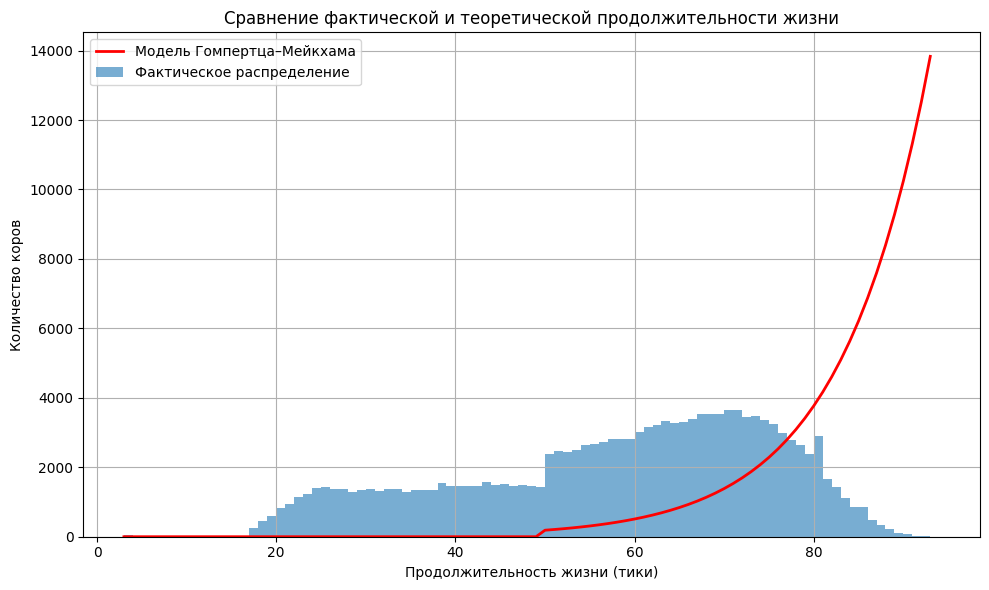

In [596]:
def plot_lifespan_with_gompertz(cows, config):
    lifespans = cows.lifespans[:cows.lifespan_count]

    counts, bins = np.histogram(lifespans, bins=range(min(lifespans), max(lifespans) + 2))
    bin_centers = (bins[:-1] + bins[1:]) / 2

    AGE_MIN = config["AGE_MIN"]
    AGE_T_WEIGHT = config["AGE_T_WEIGHT"]
    AGE_MULT = config["AGE_MULT"]

    ages = np.arange(min(lifespans), max(lifespans) + 1)
    P_theory = AGE_T_WEIGHT * np.exp(AGE_MULT * (ages - AGE_MIN))
    P_theory[ages < AGE_MIN] = 0
    P_scaled = P_theory * np.sum(counts) / np.sum(P_theory)

    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, counts, width=1, alpha=0.6, label="Фактическое распределение")
    plt.plot(ages, P_scaled, color='red', lw=2, label="Модель Гомпертца–Мейкхама")
    plt.xlabel("Продолжительность жизни (тики)")
    plt.ylabel("Количество коров")
    plt.title("Сравнение фактической и теоретической продолжительности жизни")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_lifespan_with_gompertz(simulation.cows, simulation.config_data)

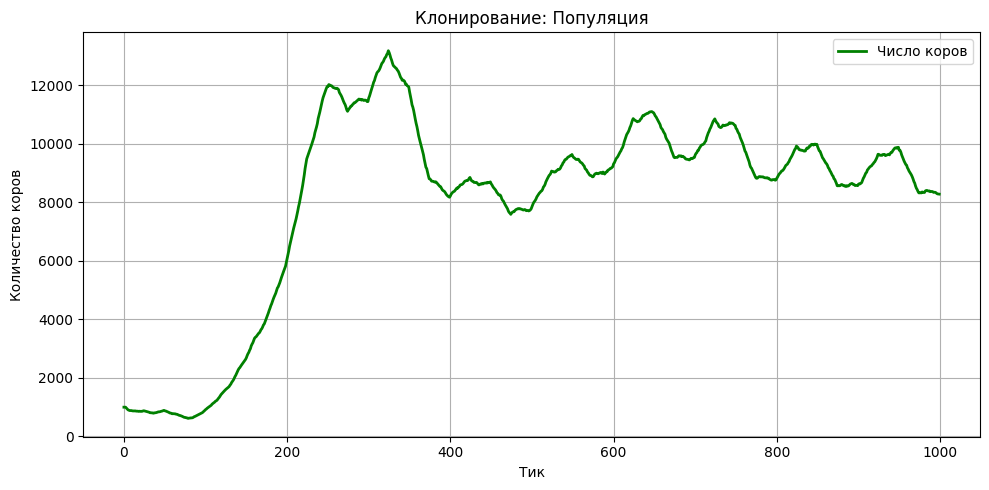

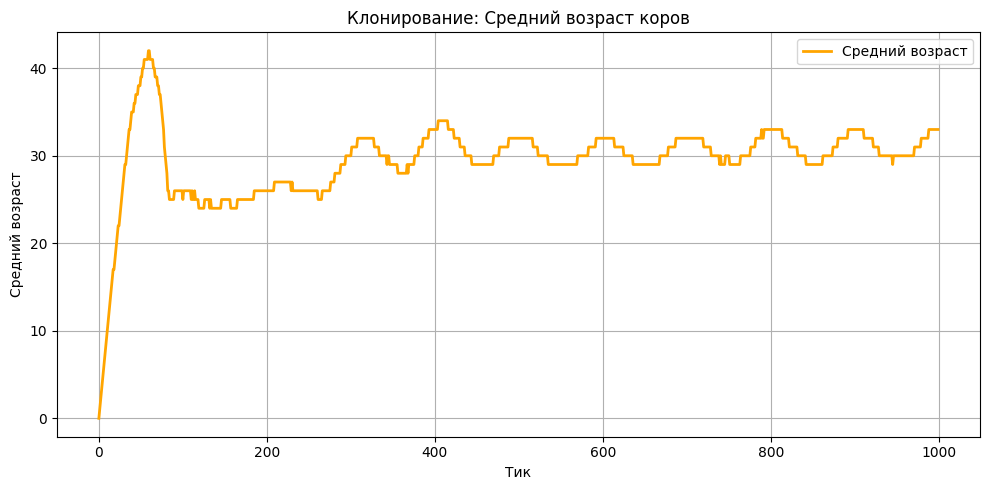

In [590]:
def plot_population(simulation, title = ""):
    with open(simulation.log_file.name, "r") as f:
        lines = f.readlines()
    
    for i, line in enumerate(lines):
        if line.strip().startswith("Tick"):
            header_idx = i
            break

    data = [line.strip().split(",") for line in lines[header_idx+1:] if line.strip() and line[0].isdigit()]
    data = np.array(data, dtype=int)

    ticks = data[:, 0]
    cow_counts = data[:, 1]
    avg_ages = data[:, 2]
    total_grass = data[:, 3]

    plt.figure(figsize=(10, 5))
    plt.plot(ticks, cow_counts, label="Число коров", linewidth=2, color="green")
    plt.xlabel("Тик")
    plt.ylabel("Количество коров")
    plt.title(f"{title}: Популяция")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(ticks, avg_ages, label="Средний возраст", linewidth=2, color="orange")
    plt.xlabel("Тик")
    plt.ylabel("Средний возраст")
    plt.title(f"{title}: Средний возраст коров")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_population(simulation, title="Клонирование")
#plot_population(simulation, title="Половое размножение")


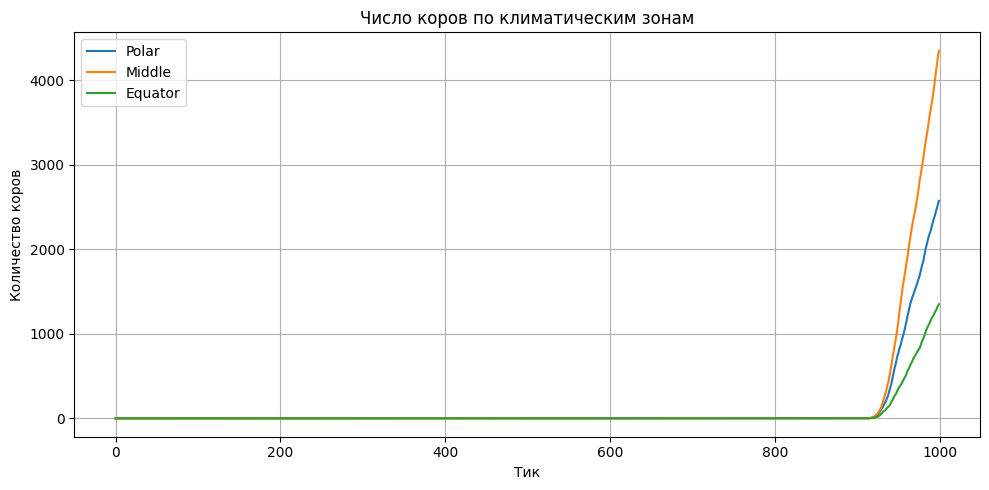

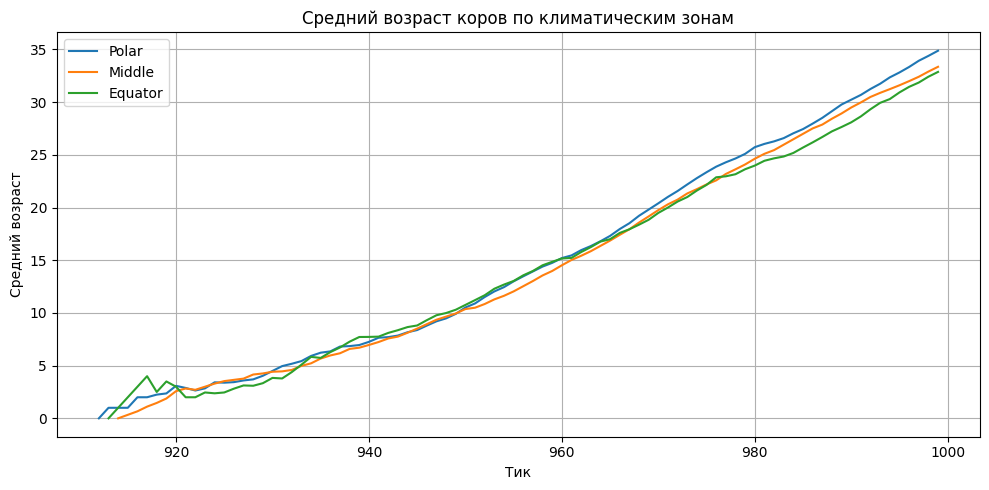

In [591]:
def plot_climate_adaptation(simulation):
    zones = ["Polar", "Middle", "Equator"]
    zone_map = {z: [] for z in zones}
    age_map = {z: [] for z in zones}
    ticks = []

    world = simulation.world
    climate_zones = world.patches.climate_zone
    tick_count = simulation.current_tick + 1

    for tick in range(tick_count):
        ticks.append(tick)

        cows = simulation.cows.matrix[:simulation.cows.count]
        birth = cows[:, Cow.IDX["birth_tick"]]
        death = cows[:, Cow.IDX["death_tick"]]
        pos = cows[:, Cow.IDX["position"]]

        alive = (birth <= tick) & ((death == -1) | (death > tick))
        cows_t = cows[alive]
        pos = cows_t[:, Cow.IDX["position"]]
        age = tick - cows_t[:, Cow.IDX["birth_tick"]]

        zone_groups = defaultdict(list)
        age_groups = defaultdict(list)

        for i, p in enumerate(pos):
            zone = climate_zones[p]
            zone_groups[zone].append(i)
            age_groups[zone].append(age[i])

        for z in zones:
            zone_map[z].append(len(zone_groups[z]))
            if age_groups[z]:
                age_map[z].append(np.mean(age_groups[z]))
            else:
                age_map[z].append(np.nan)

    plt.figure(figsize=(10, 5))
    for z in zones:
        plt.plot(ticks, zone_map[z], label=z)
    plt.title("Число коров по климатическим зонам")
    plt.xlabel("Тик")
    plt.ylabel("Количество коров")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    for z in zones:
        y = np.array(age_map[z], dtype=np.float32)
        plt.plot(ticks, y, label=z)
    plt.title("Средний возраст коров по климатическим зонам")
    plt.xlabel("Тик")
    plt.ylabel("Средний возраст")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_climate_adaptation(simulation)


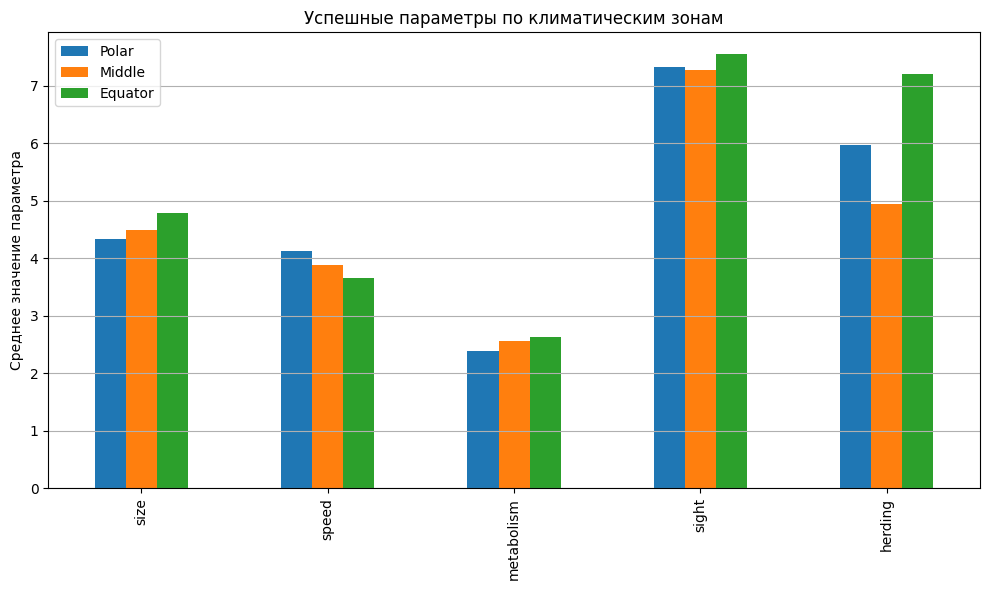

In [592]:
def analyze_successful_traits(simulation, title="Параметры успешных коров (без T0)"):
    cows = simulation.cows.active()
    world = simulation.world
    zones = ["Polar", "Middle", "Equator"]
    climate = world.patches.climate_zone

    pos = cows[:, Cow.IDX["position"]]
    zone_for_cow = np.array([climate[p] for p in pos])

    param_names = ["size", "speed", "metabolism", "sight", "herding"]
    param_indices = [Cow.IDX[p] for p in param_names]

    zone_data = {}

    for zone in zones:
        mask = zone_for_cow == zone
        if not np.any(mask):
            continue
        data = cows[mask][:, param_indices]
        means = np.mean(data, axis=0)
        zone_data[zone] = means

    df = pd.DataFrame(zone_data, index=param_names)

    df.plot(kind="bar", figsize=(10, 6))
    plt.title(title)
    plt.ylabel("Среднее значение параметра")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    return df

    
df = analyze_successful_traits(simulation, title="Успешные параметры по климатическим зонам")


Запуск с MUTATION_RATE = 0.0
Запуск с MUTATION_RATE = 0.1
Запуск с MUTATION_RATE = 0.2
Запуск с MUTATION_RATE = 0.3
Запуск с MUTATION_RATE = 0.5


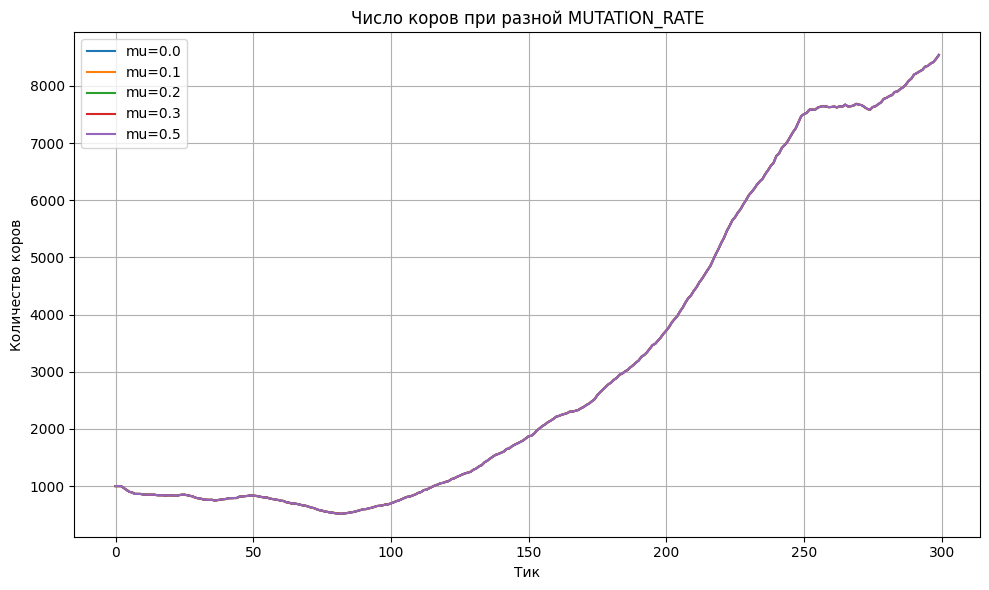

In [593]:
import copy

def run_mutation_experiment(base_config, mutation_rates, max_ticks=300):
    results = {}

    for rate in mutation_rates:
        print(f"Запуск с MUTATION_RATE = {rate}")
        config = copy.deepcopy(base_config)
        config["MUTATION_RATE"] = rate
        config["TIME"] = max_ticks

        sim = Simulation(config)
        sim.run()
        results[rate] = sim

    return results
mutation_rates = [0.0, 0.1, 0.2, 0.3, 0.5]
experiments = run_mutation_experiment(config_data, mutation_rates)



def plot_population_vs_mutation(experiments):
    plt.figure(figsize=(10, 6))

    for rate, sim in experiments.items():
        ticks = []
        cow_counts = []
        with open(sim.log_file.name, "r") as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if line.strip().startswith("Tick"):
                header_index = i
                break
        data = lines[header_index+1:]
        for line in data:
            if line.strip() and line[0].isdigit():
                tick, count, *_ = map(int, line.strip().split(","))
                ticks.append(tick)
                cow_counts.append(count)
        plt.plot(ticks, cow_counts, label=f"mu={rate}")

    plt.title("Число коров при разной MUTATION_RATE")
    plt.xlabel("Тик")
    plt.ylabel("Количество коров")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_population_vs_mutation(experiments)
